<a href="https://colab.research.google.com/github/nitesh-dubey/Neural-Image-Captioning/blob/master/Neural_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Image Captioning
--*Nitesh Dubey - IIIT Guwahati*

This notebook shows an image captioning system which gives a short description of the input image using Merge Architecture.
The Dataset used for training and testing the model is ***Flickr Dataset***.

Lets get started...

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_path = '/content/gdrive/My Drive/Colab Notebooks/Image Captioning/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import re
import pickle
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import Input, Dropout, LSTM, Dense, Embedding, Add, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.CRITICAL)

Using TensorFlow backend.


We need to pass images to InceptionV3, to get its features, but this step is redundant. Instead of passing image to model every time to get its features, we can instead, save the encoded features of all the images in a dictonary at once,which will speed up training.

# ***Data Preparation***

# Preparing Image Data

In [0]:
def get_features(img_dir):
  model = InceptionV3()
  model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
  img_features = dict()
  for imgname in listdir(img_dir):
    img_path = img_dir + imgname
    image = load_img(img_path, target_size = (299,299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image)
    imgname = imgname.split('.')[0]
    img_features[imgname] = feature
  return img_features

img_dir = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/'

In [0]:
# Run only Once
img_features = get_features(img_dir)
print('Number of Image Feautres : ' + str(len(img_features)))
pickle.dump(img_features,open(dir_path + 'img_features.pickle', 'wb'))

96116736/96112376 [==============================] - 1s 0us/step
Number of Image Feautres : 8091


The image features are saved to disk. Now the text data needs to preprocessed.

# Preparing Text Data

In [0]:
!pip install contractions
import contractions

     |████████████████████████████████| 317kB 12.3MB/s 
     |████████████████████████████████| 245kB 61.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81705 sha256=b2de41606fff5ebb403ca3fab306aed47948027066b1f1a964934b91ac2ca93d
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [0]:
# Utility Functions

def load_textfile(textfile_path):
  textfile = open(textfile_path, 'r')
  text = textfile.read()
  textfile.close()
  return text

def get_captions(text):
  captions = dict()
  for line in text.split('\n'):
    tokens = line.split()
    if(len(tokens) < 2): continue
    img_name, caption = tokens[0].split('.')[0], tokens[1:]
    caption = ' '.join(caption)
    if img_name not in captions:
      captions[img_name] = list()
    captions[img_name].append(caption)
  return captions

def clean_captions(captions):
  for img, caption_list in captions.items():
    for i in range(len(caption_list)):
      caption = caption_list[i].lower()
      caption = re.sub(r'[^a-zA-Z\s]', '',caption)
      caption = ' '.join([w for w in caption.split() if len(w) >= 2])
      caption = re.sub(r'[\s]+', ' ', caption)
      caption = contractions.fix(caption)
      caption_list[i] = 'startseq ' + caption + ' endseq'
  return captions

def get_vocab(captions):
  all_words = set()
  for key in captions.keys():
    [all_words.update(d.split()) for d in captions[key]]
  return all_words

def save_captions(captions, filename):
  lines = list()
  for keys, cap_list in captions.items():
    for caption in cap_list:
      lines.append(keys + ' ' + caption)
  lines = '\n'.join(lines)
  with open(filename, 'w') as f:
    f.write(lines)


In [0]:
# Run only Once
# Cleaning and saving the Captions

text = load_textfile(dir_path + 'Data/Flickr8k_text/Flickr8k.token.txt')
captions = get_captions(text)
captions = clean_captions(captions)
save_captions(captions, dir_path + 'cleaned_captions.txt')

In [0]:
# Getting The names of the training, validation and test images

def get_data(filename):
  f = open(filename, 'r')
  names = f.read().strip().split('\n')
  names = [x.split('.')[0] for x in names]
  f.close()
  return names

train_img = get_data(dir_path + 'Data/Flickr8k_text/Flickr_8k.trainImages.txt')
val_img = get_data(dir_path + 'Data/Flickr8k_text/Flickr_8k.devImages.txt')
test_img = get_data(dir_path + 'Data/Flickr8k_text/Flickr_8k.testImages.txt')


In [0]:
# Loading the Training, validation and cleaned captions

def load_clean_captions(file_path,dataset):
  captions = dict()
  f = load_textfile(file_path)
  for line in f.split('\n'):
    tokens = line.split()
    img_name, caption = tokens[0], tokens[1:]
    caption = ' '.join(caption)
    if img_name in dataset:
      if img_name not in captions:
        captions[img_name] = list()
      captions[img_name].append(caption)
  return captions

train_captions = load_clean_captions(dir_path + 'cleaned_captions.txt', set(train_img))
val_captions = load_clean_captions(dir_path + 'cleaned_captions.txt', set(val_img))
test_captions = load_clean_captions(dir_path + 'cleaned_captions.txt', set(test_img))


['startseq child playing on rope net endseq',
 'startseq little girl climbing on red roping endseq',
 'startseq little girl in pink climbs rope bridge at the park endseq',
 'startseq small child grips onto the red ropes at the playground endseq',
 'startseq the small child climbs on red ropes on playground endseq']

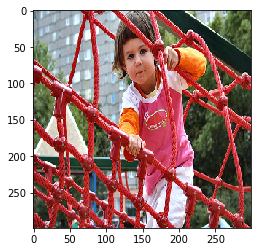

In [0]:
#Example
plt.imshow(load_img(dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '1007320043_627395c3d8' + '.jpg', target_size=(299,299)))
train_captions['1007320043_627395c3d8']

In [0]:
# Run Only Once
# Removing Rare words:

# The words which occur less than 5 times in the captions shall be removed
wordfreq = dict()
for img_name, cap_list in train_captions.items():
  for cap in cap_list:
    for w in cap.split():
      if w not in wordfreq:
        wordfreq[w] = 1
      else:
        wordfreq[w] += 1

vocab = [w for w in wordfreq if wordfreq[w] >= 5]
print('Previous vocabulary :', len(wordfreq), '\n' + 'Vocabulary for Removing Rare Words :', len(vocab))

Previous vocabulary : 7575 
Vocabulary for Removing Rare Words : 2530


In [0]:
# Run Only Once
# Building Word to Index, and Index to Word tokenizer
wordtoix, ixtoword = dict(), dict()
ix = 1
for w in vocab:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1

# Saving wordtoix and ixtoword tokenizers
pickle.dump(wordtoix, open(dir_path + 'wordtoix.pickle', 'wb'))
pickle.dump(ixtoword, open(dir_path + 'ixtoword.pickle', 'wb'))

In [0]:
wordtoix = pickle.load(open(dir_path + 'wordtoix.pickle', 'rb'))
ixtoword = pickle.load(open(dir_path + 'ixtoword.pickle', 'rb'))
vocab_size = len(ixtoword) + 1   # +1 for 0's padding
img_features = pickle.load(open(dir_path + 'img_features.pickle', 'rb'))

In [0]:
# Finding Maxlength of captions
maxlen = 0
for key, cap_list in train_captions.items():
  for cap in cap_list:
    maxlen = max(maxlen, len(cap.split()))
print('Maximum Caption Length :',maxlen)

Maximum Caption Length : 34


In [0]:
# Building Data Generator
def data_generator(img_features, captions, wordtoix, max_len, batch_size):
  ImgBatch, InBatch, OutBatch = list(), list(), list()
  count = 0
  while True:
    for img_name, cap_list in captions.items():
      count += 1
      for cap in cap_list:
        seq = [wordtoix[w] for w in cap.split() if w in wordtoix]
        for i in range(len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen = max_len)[0]
          out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
          ImgBatch.append(img_features[img_name][0])
          InBatch.append(in_seq)
          OutBatch.append(out_seq)
      if count == batch_size:
        yield [[np.array(ImgBatch), np.array(InBatch)], np.array(OutBatch)]
        ImgBatch, InBatch, OutBatch = list(), list(), list()
        count = 0


In [0]:
# Run only Once
# Loading Glove Embedding
glove_path = dir_path + 'glove.6B.200d.txt'
embedding_index = dict()
with open(glove_path, encoding = 'utf-8') as f:
  for line in f:
    value = line.split()
    word, coeff = value[0], value[1:]
    embedding_index[word] = np.asarray(coeff, dtype = 'float32')
print('Number of Word vector :', len(embedding_index))

Number of Word vector : 400000


In [0]:
# Run only once
# Making Embedding Matrix
emb_dim = 200
embedding_matrix = np.zeros((vocab_size, emb_dim))
for word, ix in wordtoix.items():
  if word in embedding_index:
    embedding_matrix[ix] = embedding_index[word]
print('Embedding Matrix Shape :', embedding_matrix.shape)

Embedding Matrix Shape : (2531, 200)


# Model Building - ***Merge Architecture***

In [0]:
# Run only once
input1 = Input(shape=(2048,))
img = Dropout(0.5)(input1)
img = Dense(256, activation = 'relu')(img)
input2 = Input(shape=(maxlen,))
text = Embedding(vocab_size, emb_dim, mask_zero=True)(input2)
text = Dropout(0.5)(text)
dec = LSTM(256)(text)
dec = keras.layers.Add()([img, dec])
dec = Dense(256, activation='relu')(dec)
dec = Dense(vocab_size, activation='softmax')(dec)
model = Model(inputs = [input1, input2], outputs = [dec])

In [0]:
# Run only once
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      506200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
# Run only once
model.layers[2]

In [0]:
# Run only once
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
# Run only once
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      506200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
# Run only once
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
# Run only once
epochs = 30
batch_size = 3
steps_per_epoch = len(train_captions)//batch_size

In [0]:
# Run only once
for i in range(epochs):
  generator = data_generator(img_features, train_captions, wordtoix, maxlen, batch_size)
  model.fit_generator(generator, steps_per_epoch=steps_per_epoch, epochs=1, verbose=1)
  model.save(dir_path + 'Models/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 163s 81ms/step - loss: 3.9609
Epoch 1/1
2000/2000 [==============================] - 157s 79ms/step - loss: 3.2454
Epoch 1/1
2000/2000 [==============================] - 150s 75ms/step - loss: 3.0116
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.8732
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.7736
Epoch 1/1
2000/2000 [==============================] - 147s 74ms/step - loss: 2.6986
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.6396
Epoch 1/1
2000/2000 [==============================] - 146s 73ms/step - loss: 2.5904
Epoch 1/1
2000/2000 [==============================] - 147s 73ms/step - loss: 2.5509
Epoch 1/1
2000/2000 [==============================] - 146s 73ms/step - loss: 2.5175
Epoch 1/1
2000/2000 [==============================] - 146s 73ms/step - loss: 2.4869
Epoch 1/1
2000/2000 [==============================] - 149s 74ms/

# Inference using ***GreedyDecoder*** and ***BeamSearch Decoder***

In [0]:
# Run once during prediction
img_model = InceptionV3()
img_model = Model(inputs = img_model.inputs, outputs = img_model.layers[-2].output)

96116736/96112376 [==============================] - 3s 0us/step


In [0]:
# Run once During Prediction
# Greedy Search Decoder
def greedysearch(finalmodel, img):
  in_seq = 'startseq'
  for i in range(maxlen):
    seq = [wordtoix[w] for w in in_seq.split() if w in wordtoix]
    seq = pad_sequences([seq], maxlen = maxlen)[0]
    ypred = finalmodel.predict([img, seq.reshape(1, seq.shape[0])])
    ypred = np.argmax(ypred)
    word = ixtoword[ypred]
    if word == 'endseq':
      break
    in_seq += ' ' + word
  out_seq = ' '.join(in_seq[9:].split())
  return out_seq


# Beam Search Decoder
def beamsearch(finalmodel, img, k=3):
  beam_dec = [('startseq', 0.0)] * k

  for i in range(maxlen):
    temp = None
    for text, l_prob in beam_dec:
      seq = [wordtoix[w] for w in text.split() if w in wordtoix]
      seq = pad_sequences([seq], maxlen = maxlen)[0]
      probs = finalmodel.predict([img, seq.reshape(1, seq.shape[0])])
      log_probs = np.log(probs)[0]
      beamind = np.argsort(log_probs).tolist()[-k:]

      inter = [(text + ' ' + ixtoword[ind], l_prob + log_probs[ind]) for ind in beamind]
      if temp == None:
        temp = inter
      else:
        temp += inter
    beam_dec = sorted(temp, key = lambda x : x[1])[-k:]
  decoded = beam_dec[-1][0]
  if 'startseq' in decoded: decoded = decoded.replace('startseq', '')
  result = list()
  for x in decoded.split():
    if x == 'endseq': break
    else: result.append(x)
  return ' '.join(result)



def predict(finalmodel, image_path, decoder = 'greedy'):
  image = load_img(image_path, target_size = (299,299))
  plt.imshow(image)
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = img_model.predict(image)
  if decoder == 'greedy':
    return greedysearch(finalmodel, feature)
  elif decoder == 'beam':
    return beamsearch(finalmodel, feature)
  else:
    return 'Enter valid decoder type'

In [0]:
finalmodel = keras.models.load_model(dir_path + 'Models/' + 'model_29.h5')

Greedy Search Decoder : group of people are standing around store counter
Beam Search Decoder : group of people are standing around store counter


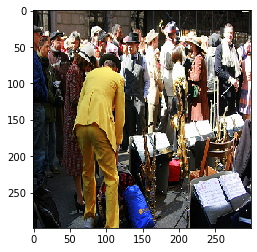

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '3554634863_5f6f616639' + '.jpg'
print("Greedy Search Decoder :", predict(finalmodel, image_path, 'greedy'))
print("Beam Search Decoder :", predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : man in red jacket is walking through snow
Beam Search Decoder : man in red jacket is walking through snow


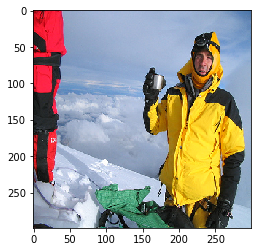

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '55470226_52ff517151' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : two horses are racing around the corner of the gate
Beam Search Decoder : two horses are racing around the corner of the gate


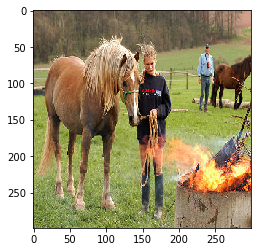

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '10815824_2997e03d76' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : man in red shirt is riding bike on the street
Beam Search Decoder : man in red shirt is riding bike on the street


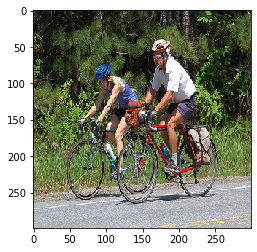

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '199463720_329a802206' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : man is climbing up snowy mountainside
Beam Search Decoder :  man is climbing up snowy mountainside                            


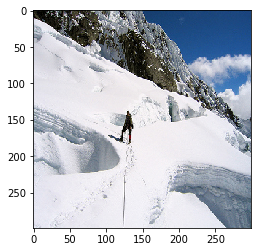

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '270809922_043e3bef06' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : man in red shirt rides bike down the road
Beam Search Decoder :  man in red shirt rides bike down the road                         


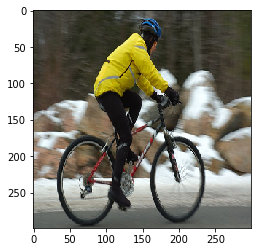

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '358114269_96fdb5f7c3' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : two dogs are playing together in the grass
Beam Search Decoder :  two dogs are playing together in the grass                          


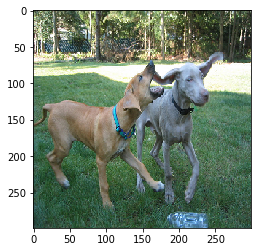

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '123889082_d3751e0350' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : dog is running through the water
Beam Search Decoder : dog is running through the water


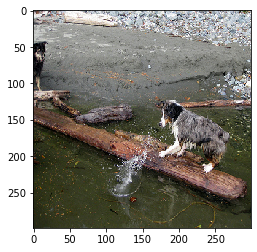

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '2878272032_fda05ffac7' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : two dogs are running through the grass
Beam Search Decoder : two dogs are running through the grass


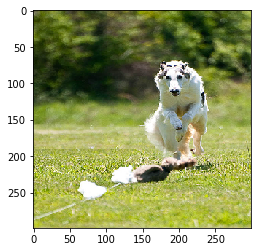

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '3540416981_4e74f08cbb' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : man is cleaning on narrow fountain
Beam Search Decoder : man is cleaning on narrow fountain


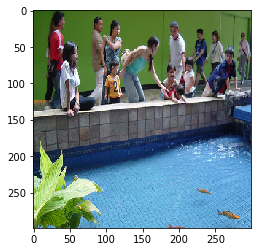

In [0]:
image_path = dir_path + 'Data/Flickr8k_Dataset/Flicker8k_Dataset/' + '12830823_87d2654e31' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

Greedy Search Decoder : man in cast shirt gazes at the camera
Beam Search Decoder : man in cast shirt gazes at the camera


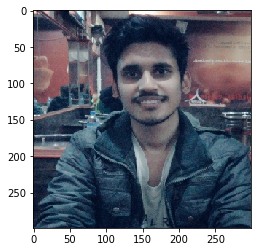

In [0]:
image_path = dir_path + 'nitesh' + '.jpg'
print('Greedy Search Decoder :', predict(finalmodel, image_path, 'greedy'))
print('Beam Search Decoder :', predict(finalmodel, image_path, 'beam'))

# Evaluation on Test set

I'll use **bleu_score** to evaluate the predicted captions

In [0]:
test_features = [img_features[img] for img in test_captions.keys()]
y = list(test_captions.values())
print(len(test_features), len(y))

1000 1000


In [0]:
yhat = [greedysearch(finalmodel, img) for img in test_features]

In [0]:
ref = [[line.split()[1:-1] for line in group] for group in y]
hypo = [desc_pred.split() for desc_pred in yhat]

In [0]:
from nltk.translate.bleu_score import corpus_bleu

In [0]:
bleu_score = corpus_bleu(ref, hypo, weights = (1, 0, 0, 0))
print("Bleu Score =", bleu_score)

Bleu Score = 0.44722908577479703


# ***Conclusion*** :
We can see that although there are few errors in predictions, but most of the predictions are reasonable and meaningful.

These errors can be improved by using more Data and using better architectures.